In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2025-04-14 21:50:59.466205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744642259.535947    6758 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744642259.556864    6758 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744642259.695733    6758 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744642259.695775    6758 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744642259.695780    6758 computation_placer.cc:177] computation placer alr

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 5

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

W0000 00:00:1744642266.055377    6758 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125 (4.39 KB)

 Trainable params: 1,125 (4.39 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/29 ━━━━━━━━━━━━━━━━━━━━ 25s 927ms/step - accuracy: 0.1094 - loss: 1.7848
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1305 - loss: 1.7184 - val_accuracy: 0.3150 - val_loss: 1.5393
Epoch 2/1000
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1953 - loss: 1.5988
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2646 - loss: 1.5526 - val_accuracy: 0.4545 - val_loss: 1.4026
Epoch 3/1000
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2891 - loss: 1.4763
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3811 - loss: 1.4299 - val_accuracy: 0.5798 - val_loss: 1.2640
Epoch 4/1000
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4062 - loss: 1.3678
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.ke

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9460 - loss: 0.2558 


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[7.5569987e-02 7.7454084e-01 1.4979839e-01 9.0103145e-05 6.0189296e-07]
1


# Confusion matrix

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step


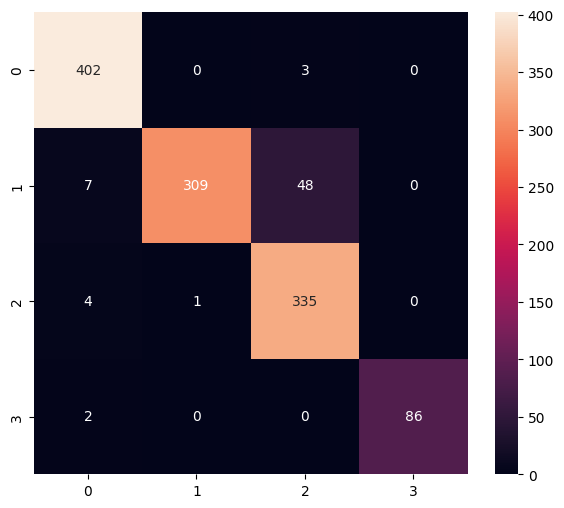

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       405
           1       1.00      0.85      0.92       364
           2       0.87      0.99      0.92       340
           3       1.00      0.98      0.99        88

    accuracy                           0.95      1197
   macro avg       0.96      0.95      0.95      1197
weighted avg       0.95      0.95      0.95      1197



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmp31y1rwut/assets


INFO:tensorflow:Assets written to: /tmp/tmp31y1rwut/assets


Saved artifact at '/tmp/tmp31y1rwut'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  131738567306960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131738567310992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131738563364048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131738563378640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131738563378256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131738563377488: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1744642289.020094    6758 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1744642289.020130    6758 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-14 21:51:29.020515: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp31y1rwut
2025-04-14 21:51:29.021091: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-14 21:51:29.021102: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp31y1rwut
I0000 00:00:1744642289.025410    6758 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-04-14 21:51:29.026068: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-14 21:51:29.046691: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp31y1rwut
2025-04-14 21:51:29.053873: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

6600

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

/mnt/01DB783D25219E60/HOMEWORK/TGMT/ThiGiacPC/AI/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 45 μs, sys: 1.01 ms, total: 1.06 ms
Wall time: 568 μs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[7.5570047e-02 7.7454084e-01 1.4979839e-01 9.0103320e-05 6.0189348e-07]
1
